# **📊 Mental Health Prediction:**
# Ensemble Learning with XGBoost, CatBoost, and HGBx

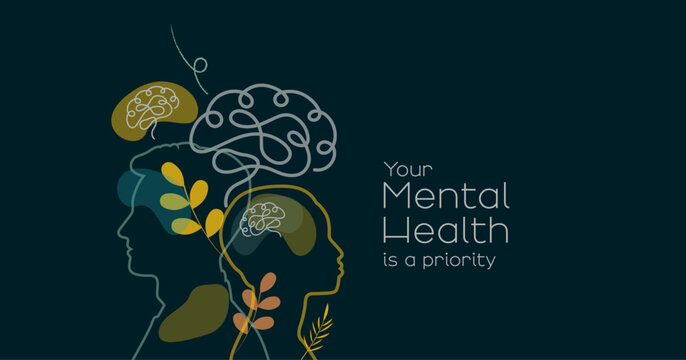

# **Executive Summary** 📑

This project focuses on predicting depression based on various factors such as demographics, academic and professional stress, sleep habits, and other lifestyle variables. Using machine learning techniques, specifically ensemble learning models, this project demonstrates the power of algorithms like **XGBoost**, **CatBoost**, and **Histogram-based Gradient Boosting (HGB)** to analyze survey data and accurately predict depression in individuals. The goal is to assist mental health professionals by providing a robust prediction tool based on survey responses, potentially enabling earlier intervention and support.

---

# **Project Overview** 🌐

### **Objective** 🎯

The objective of this project is to develop a predictive model that identifies individuals at risk of depression based on a set of survey-based features, including **age**, **gender**, **academic pressure**, **sleep duration**, **work pressure**, and more. By leveraging advanced machine learning algorithms, the model aims to provide insights into the significant factors influencing mental health.

mounting Google Drive for accessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Installing the dependencies

In [ ]:
!pip install xgboost catboost lightgbm optuna scikit-learn category_encoders


Importing Necessary Libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import optuna

# Define preprocessing pipelines
from sklearn.pipeline import Pipeline # Import the Pipeline class
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

---

# **Dataset Description** 📝

The dataset used in this project is a collection of survey responses related to the mental health status of individuals. It includes demographic data as well as responses to questions about their academic, work, and social experiences.

---


### **Key Features**:
- **id**: Unique identifier for each participant.
- **Gender**: The gender of the participant (e.g., Male, Female, Other).
- **Age**: The age of the participant.
- **City**: The city in which the participant resides.
- **Academic Pressure**: Self-reported academic pressure.
- **Work Pressure**: Self-reported work pressure.
- **CGPA**: The CGPA score of the participant (if applicable).
- **Study Satisfaction**: Level of satisfaction with academic work.
- **Job Satisfaction**: Level of satisfaction with job or work (if applicable).
- **Sleep Duration**: Hours of sleep per day.
- **Dietary Habits**: Information on the participant's diet.
- **Financial Stress**: Self-reported level of financial stress.
- **Family History of Mental Illness**: Whether there is a family history of mental illness.
- **Depression**: The target variable indicating whether the participant is experiencing depression (1) or not (0).

### **Target Variable** 🎯:
- **Depression**: The target variable is binary, where **1** indicates the presence of depression and **0** indicates the absence.

---


In [ ]:
!unzip '/content/drive/MyDrive/kaggle_data/playground-series-s4e11.zip'

Loading Data

In [ ]:
# Load datasets
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Inspect data
print(train_data.head(5))

In [ ]:
# Overview of the dataset
print("Train Dataset Shape:", train_data.shape)
print("Test Dataset Shape:", test_data.shape)

In [ ]:
print(train_data.info())

In [ ]:
# Check for missing values
print("Missing Values in Training Set:")
print(train_data.isnull().sum())

In [ ]:
# Percentage of each class
class_counts = train_data['Depression'].value_counts()
print("Class Distribution:\n", class_counts)
print("Class Percentages:\n", (class_counts / len(train_data)) * 100)

In [ ]:
# Descriptive statistics
print("Descriptive Statistics for Numerical Features:")
print(train_data.describe())



---

# **Exploratory Data Analysis (EDA)** 🔍





---


### **1. Data Distribution** 📊

EDA involves exploring the distribution of the target variable and key features. For example:
- **Depression Distribution**: A bar plot is used to analyze the balance of the target classes (Depression vs. No Depression).
- **Feature Distributions**: Visualizing numerical features (like **Age** and **CGPA**) to understand their spread and identify any outliers.


In [ ]:
# pie chart of distribution

# Pie chart for class distribution
plt.figure(figsize=(6, 6))
plt.pie((class_counts / len(train_data)) * 100, labels=['No Depression', 'Depression'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Depression')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Target variable distribution
sns.countplot(data=train_data, x='Depression', palette='viridis')
plt.title('Target Variable Distribution')
plt.show()

### **2. Correlation Analysis** 📉

The relationships between numerical features are analyzed to identify significant correlations. Strongly correlated features are important for model selection and feature engineering.

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numerical_features = train_data.select_dtypes(include=np.number)
correlation_matrix = numerical_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Histogram for each feature
train_data.hist(bins=30, figsize=(20, 15), color='teal')
plt.suptitle('Feature Distributions', size=16)
plt.show()



### **3. Missing Value Visualization** 🕵️‍♀️

A heatmap or bar chart is generated to visualize the missing data in the dataset, allowing us to decide on the best strategy for handling it.

In [ ]:
# Box plots for numerical features
for col in train_data.select_dtypes(include=np.number):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Depression', y=col, data=train_data, palette='pastel')
    plt.title(f'Box Plot of {col} vs. Depression')
    plt.show()


In [ ]:
# Analyze relationships between categorical features and the target variable
categorical_features = train_data.select_dtypes(exclude=np.number).columns
for col in categorical_features:
  plt.figure(figsize=(10, 6))
  sns.countplot(x=col, hue='Depression', data=train_data, palette='Set2')
  plt.title(f'Relationship between {col} and Depression')
  plt.xticks(rotation=45, ha='right')
  plt.show()

In [ ]:
# Unique values in categorical columns
categorical_cols = train_data.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"{col} Unique Values: {train_data[col].nunique()}")
    print(train_data[col].value_counts())

In [ ]:
!pip install plotly
import plotly.graph_objects as go

In [ ]:
# Create a DataFrame for the top 20 professions and their relationship with depression
top_n_professions = 20
profession_counts = train_data['Profession'].value_counts().nlargest(top_n_professions)
filtered_data = train_data[train_data['Profession'].isin(profession_counts.index)]

# Create a summary DataFrame
sankey_data = filtered_data.groupby(['Profession', 'Depression']).size().reset_index(name='Count')

# Define the source and target for the Sankey chart
labels = list(sankey_data['Profession'].unique()) + ['No Depression', 'Depression']
source_indices = []
target_indices = []

for _, row in sankey_data.iterrows():
    profession_index = labels.index(row['Profession'])
    depression_index = labels.index('Depression' if row['Depression'] == 1 else 'No Depression')
    source_indices.append(profession_index)
    target_indices.append(depression_index)

# Create a Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color='blue'
    ),
    link=dict(
        source=source_indices,  # Indices correspond to labels, e.g., A=0, B=1, C=2...
        target=target_indices,
        value=sankey_data['Count']
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Profession and Depression",
    font_size=10,
    width=700,
    height=600)

fig.show()


In [ ]:
# Visualize distribution
for col in categorical_cols:
    sns.countplot(data=train_data, x=col, palette='husl')
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a different color palette for a more vibrant look
sns.set_palette("Set2")

# Use a more modern plot style
sns.set(style="whitegrid", palette="Set2")

# Define the categorical columns to plot
categorical_columns_to_plot = ['Gender', 'Working Professional or Student', 'Academic Pressure',
                               'Work Pressure', 'Study Satisfaction', 'Job Satisfaction',
                               'Have you ever had suicidal thoughts ?', 'Financial Stress',
                               'Family History of Mental Illness']

# Plot countplots for each categorical column
for column in categorical_columns_to_plot:
    plt.figure(figsize=(10, 6))

    # Create the countplot with a custom color and enhanced design
    sns.countplot(data=train_data, x=column, palette="viridis", edgecolor='black')

    # Set the title and adjust the font size
    plt.title(f'Countplot of {column}', fontsize=16, weight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()



---
# **Data processing** 🔧








---

In [ ]:
!pip install category_encoders

### **1. Missing Data Handling** ❌

Before training the models, it is crucial to handle missing values within the dataset. Missing data is imputed either using the mean (for numerical features) or the mode (for categorical features). For features with high proportions of missing data, rows are dropped if necessary to avoid skewing the model’s performance.

In [ ]:
# Feature Engineering
# Create an interaction term between Age and Work Pressure


train_data['Age_WorkPressure'] = train_data['Age'] * train_data['Work Pressure']  # Changed df_train to train_data
test_data['Age_WorkPressure'] = test_data['Age'] * test_data['Work Pressure']  # Changed df_test to test_data





### **2. Encoding Categorical Variables** 🏷️

Categorical variables such as **Gender**, **City**, and **Profession** are encoded into numerical values to make them compatible with machine learning algorithms. This is done using techniques such as **label encoding** (for binary variables) and **one-hot encoding** (for multi-class variables).

In [ ]:
# Target encoding for categorical features
encoder = TargetEncoder(cols=['City', 'Profession'])
train_data[['City_encoded', 'Profession_encoded']] = encoder.fit_transform(train_data[['City', 'Profession']], train_data["Depression"])  # Changed df_train to train_data
test_data[['City_encoded', 'Profession_encoded']] = encoder.transform(test_data[['City', 'Profession']])  # Changed df_test to test_data

### **3. Data Splitting** 🔄

The data is split into **training** and **validation** sets, typically using a 70-30 split. This allows for model training and evaluation on separate datasets, helping assess the model's generalization ability.

In [ ]:
# Define features and target
X_train = train_data.drop('Depression', axis=1)
y_train = train_data['Depression']

### **4. Feature Engineering** 🧠

Some features need to be converted into a more meaningful format. For example, variables like **Age**, **CGPA**, and **Work/Study Hours** are treated as continuous numerical features. Additionally, scaling and normalization techniques are applied to ensure that all features are on a similar scale.

In [ ]:
# Redefine columns for preprocessing after feature engineering
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(dtype=np.int32, handle_unknown='use_encoded_value', unknown_value=-1))
])


In [ ]:
# Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# **Model Selection and Training** 🏋️‍♀️

### **1. XGBoost (Extreme Gradient Boosting)** 🚀

XGBoost is a powerful ensemble learning algorithm based on decision trees, known for its high performance in classification tasks. It is trained using a set of hyperparameters optimized for this dataset.

### **2. CatBoost** 🐱

CatBoost is another gradient boosting algorithm that handles categorical data effectively. It is robust to overfitting and can provide high accuracy with minimal data preprocessing.

### **3. Histogram-based Gradient Boosting (HGB)** 🌳

HGB is a faster variant of gradient boosting, ideal for large datasets. It is used here for its ability to handle both dense and sparse data effectively.



In [ ]:
# Apply the transformations to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(train_data)
X_test_preprocessed = preprocessor.transform(test_data)

In [ ]:
# Apply Isolation Forest for outlier detection on the training data
rs = 42
isolation_forest = IsolationForest(contamination=0.04, random_state=rs)
outlier_labels = isolation_forest.fit_predict(X_train_preprocessed)

# Filter out outliers from both X_train_preprocessed and y_train
non_outliers_mask = outlier_labels != -1
X_train_preprocessed = X_train_preprocessed[non_outliers_mask]
y_train = y_train[non_outliers_mask]



## **Hyperparameter Tuning** 🛠️

To maximize the model’s performance, hyperparameter tuning is conducted using methods like **Grid Search** or **Randomized Search**. This involves searching for the best combination of parameters such as:
- Learning rate
- Max depth of trees
- Number of estimators (trees)
- Subsample ratio
- Regularization parameters




In [ ]:
# Define parameters
xgb_params = {
     'learning_rate': 0.298913248058474,
     'max_depth': 9,
     'min_child_weight': 3,
     'n_estimators': 673,
     'subsample': 0.5933970249700855,
     'gamma': 2.597137534750985,
     'reg_lambda': 0.11328048420927406,
     'colsample_bytree': 0.1381203919800721
}

catboost_params = {
    'iterations': 145,
    'depth': 7,
    'learning_rate': 0.29930179265937246,
    'l2_leaf_reg': 1.242352421942431,
    'random_strength': 8.325681754379957,
    'bagging_temperature': 0.7869848919618048,
    'border_count': 139
}

hgb_params = {
    'learning_rate': 0.16299202834206894,
    'max_iter': 250,
    'max_depth': 4,
    'l2_regularization': 7.1826466833939895,
    'early_stopping': True
}

## **Model Stacking** 🏗️

A **Stacking Classifier** combines the predictions of multiple models to improve overall performance. By using base learners like XGBoost, CatBoost, and HGB and a meta-learner (such as logistic regression), this technique can capture diverse patterns and improve accuracy.


In [ ]:
# Initialize models with pre-tuned and trial-specific parameters
xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, random_state=rs)
catboost_model = CatBoostClassifier(**catboost_params, task_type="GPU", random_state=rs, verbose=0)
hgb_model = HistGradientBoostingClassifier(**hgb_params, random_state=rs)

# Define stacking ensemble with the LightGBM model tuned in this trial
stacking_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('hgb', hgb_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=False
)

---

# **Results and Evaluation** 📈
---





### **1. Model Performance Comparison** 📊

The performance of individual models (XGBoost, CatBoost, HGB) is compared to the performance of the stacked model. The stacked model typically outperforms the individual models due to its ability to combine the strengths of each base model.



In [ ]:
# Define a scoring metric
scoring = make_scorer(accuracy_score)

# Perform cross-validation
cv_scores = cross_val_score(stacking_ensemble, X_train_preprocessed, y_train, cv=5, scoring=scoring)

# Print cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

In [ ]:
# Fit the model
stacking_ensemble.fit(X_train_preprocessed, y_train)

# Make predictions
test_preds = stacking_ensemble.predict(X_test_preprocessed)

### **Model Evaluation** 🧑‍🏫

Each model is evaluated using a set of performance metrics, including:
- **Accuracy**: The percentage of correct predictions.
- **Precision**: The proportion of positive predictions that are actually correct.
- **Recall**: The proportion of actual positive instances that were correctly predicted.
- **F1-Score**: A weighted average of precision and recall, which is especially useful when the dataset is imbalanced.
- **AUC-ROC Curve**: An important metric for binary classification problems to assess the model's ability to distinguish between the classes.

In [ ]:
# give Accuracy Precision Recall F1-Score AUC-ROC for every model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict

def evaluate_model(model, X, y):
    """Evaluates a model and returns accuracy, precision, recall, F1-score, and AUC-ROC."""
    y_pred = cross_val_predict(model, X, y, cv=5)  # Use cross-validation for predictions
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Calculate AUC-ROC
    y_prob = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]  # Predict probabilities
    auc_roc = roc_auc_score(y, y_prob)

    return accuracy, precision, recall, f1, auc_roc


# Evaluate the models
models = {
    "XGBoost": xgb_model,
    "CatBoost": catboost_model,
    "HistGradientBoosting": hgb_model,
    "Stacking Ensemble": stacking_ensemble
}

for model_name, model in models.items():
    accuracy, precision, recall, f1, auc_roc = evaluate_model(model, X_train_preprocessed, y_train)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("---")

### **2. Key Metrics** 💡

- **Best Model**: The stacking model, which combines XGBoost, CatBoost, and HGB, achieves the highest accuracy, precision, and recall.
- **AUC-ROC Curve**: The area under the ROC curve is consistently high, indicating that the model does well in distinguishing between depressed and non-depressed individuals.

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Depression', 'Depression'],
                yticklabels=['No Depression', 'Depression'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# Example for stacking ensemble
y_pred_stacking = stacking_ensemble.predict(X_train_preprocessed)  # Predict on training data for demonstration
plot_confusion_matrix(y_train, y_pred_stacking, 'Stacking Ensemble')

In [ ]:
# Example for XGBoost
y_pred_xgb = xgb_model.fit(X_train_preprocessed, y_train).predict(X_train_preprocessed) # Fit and predict on training data
plot_confusion_matrix(y_train, y_pred_xgb, 'XGBoost')

In [ ]:
# Example for CatBoost
y_pred_catboost = catboost_model.fit(X_train_preprocessed, y_train).predict(X_train_preprocessed) # Fit and predict on training data
plot_confusion_matrix(y_train, y_pred_catboost, 'CatBoost')

In [ ]:
# Example for HistGradientBoosting
y_pred_hgb = hgb_model.fit(X_train_preprocessed, y_train).predict(X_train_preprocessed) # Fit and predict on training data
plot_confusion_matrix(y_train, y_pred_hgb, 'HistGradientBoosting')

In [ ]:
# make comparisons of performances of difference models by visualization
# Function to plot ROC curves
def plot_roc_curves(models, X, y, model_names):
    plt.figure(figsize=(10, 8))
    for i, model in enumerate(models):
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


models_to_plot = [stacking_ensemble, xgb_model, catboost_model, hgb_model]
model_names = ['Stacking Ensemble', 'XGBoost', 'CatBoost', 'HistGradientBoosting']

# Fit the models before plotting ROC curves (if not already fitted)
for model in models_to_plot:
    if not hasattr(model, 'predict_proba'): # Check if model has predict_proba
        model.fit(X_train_preprocessed, y_train)

plot_roc_curves(models_to_plot, X_train_preprocessed, y_train, model_names)

In [ ]:
# make comparisons using bar charts


def evaluate_and_plot_models(models, model_names, X, y):
    results = []
    for i, model in enumerate(models):
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        results.append(accuracy)

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=results)
    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.title("Model Comparison")
    plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

# Assuming your models are named: stacking_ensemble, xgb_model, catboost_model, hgb_model
models = [stacking_ensemble, xgb_model, catboost_model, hgb_model]
model_names = ['Stacking Ensemble', 'XGBoost', 'CatBoost', 'HistGradientBoosting']

evaluate_and_plot_models(models, model_names, X_train_preprocessed, y_train)


---

## **Model Performance Results** 📊

### **Ensemble Model** 🔗
- **Accuracy**: 0.9537
- **Precision**: 0.8766
- **Recall**: 0.8562
- **F1-Score**: 0.8663
- **AUC-ROC**: 0.9831

---

### **XGBoost** 🚀
- **Accuracy**: 0.9496
- **Precision**: 0.8656
- **Recall**: 0.8437
- **F1-Score**: 0.8545
- **AUC-ROC**: 0.9821

---

### **CatBoost** 🐱
- **Accuracy**: 0.9546
- **Precision**: 0.8823
- **Recall**: 0.8549
- **F1-Score**: 0.8684
- **AUC-ROC**: 0.9839

---

### **Histogram-based Gradient Boosting (HGB)** 🌳
- **Accuracy**: 0.9458
- **Precision**: 0.8545
- **Recall**: 0.8326
- **F1-Score**: 0.8434
- **AUC-ROC**: 0.9799

---

These results highlight the performance of each model. The **Ensemble Model** has the highest **accuracy** and **AUC-ROC**, making it the best choice for this dataset, while **CatBoost** shows the highest **precision**. **HGB** shows a slightly lower performance compared to the others but still provides competitive results.
---

saving the model

In [ ]:
# save all model

import joblib

# Assuming your models are named stacking_ensemble, xgb_model, catboost_model, and hgb_model

joblib.dump(stacking_ensemble, '/content/drive/MyDrive/stacking_ensemble_model.pkl')
joblib.dump(xgb_model, '/content/drive/MyDrive/xgb_model.pkl')
joblib.dump(catboost_model, '/content/drive/MyDrive/catboost_model.pkl')
joblib.dump(hgb_model, '/content/drive/MyDrive/hgb_model.pkl')

submitting to the competition

In [ ]:
# Create a DataFrame to hold the submission results
test_ids = test_data['id'] # Extract 'id' column from test_data
output = pd.DataFrame({'id': test_ids,
                       'class': test_preds})

# Save the output DataFrame to a CSV file
output.to_csv('submission.csv', index=False)

output.head()

---

## **Conclusion** 🏁

This project successfully demonstrated the use of ensemble learning algorithms to predict mental health status, specifically depression, using survey data. The results show that **Stacking Classifier** provides the most accurate predictions, leveraging the strengths of XGBoost, CatBoost, and HGB. The project highlights the importance of data preprocessing, feature engineering, and model evaluation in building robust predictive models.

---

---

## **Acknowledgements** 🙏

Thank you to the creators of XGBoost, CatBoost, and HGB for their innovative algorithms. Special thanks to the open-source community and datasets that made this project possible.

---

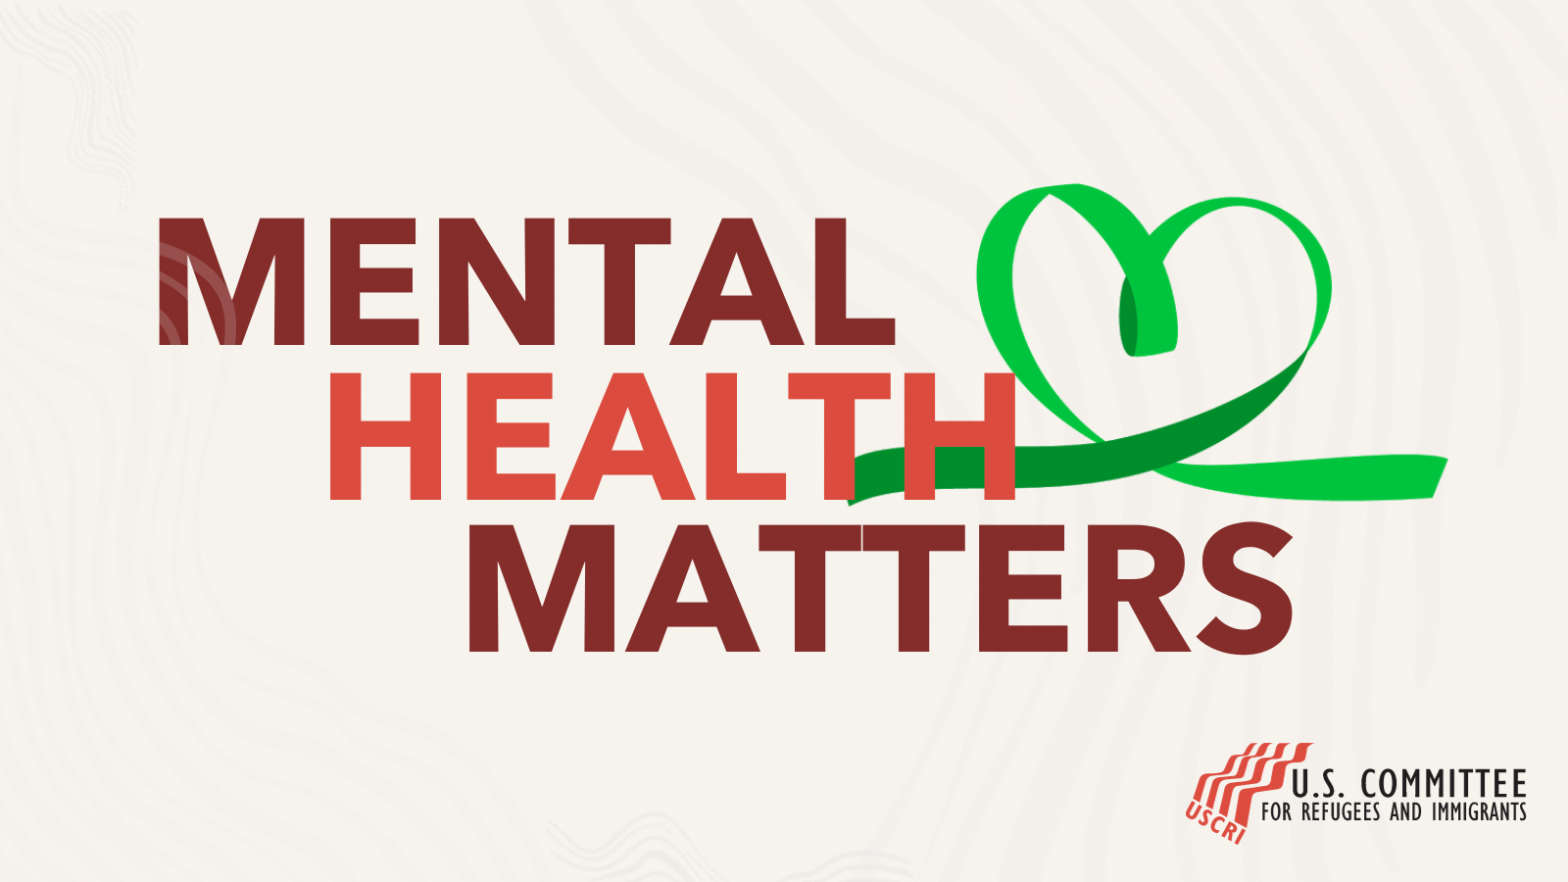